In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from helper_functions import *
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [3]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from keras.layers.experimental.preprocessing import RandomCrop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
import keras

Using TensorFlow backend.


ModuleNotFoundError: No module named 'keras.layers.experimental'

In [ ]:
# Mount if you want to run in google colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Make sure that the graphics card appears in the device list
# If this is not the case in google colab, then change the runtime type to GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
project_root_dir = "/content/drive/MyDrive/cs-433-project-2-team-afm/"
#project_root_dir = "./"
model_name = "test_model"

# Preprocessing

## Set seeds

In [1]:
import random
SEED = 1

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')

NameError: name 'os' is not defined

## Load images

In [7]:
from natsort import natsorted

# Loaded a set of images
root_dir = project_root_dir + "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

test_images_dir = project_root_dir + "data/test_set_images/"
files = os.listdir(test_images_dir)
files = natsorted(files)
n = len(files)
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_images_dir + files[i]) for i in range(n)]

Loading 100 images
Loading 100 images
Loading 50 images


In [8]:
imgs = np.array(imgs)
gt_imgs = np.expand_dims(np.array(gt_imgs), -1)
test_imgs = np.array(test_imgs)
print(imgs.shape)
print(gt_imgs.shape)
print(test_imgs.shape)

(100, 400, 400, 3)
(100, 400, 400, 1)
(50, 608, 608, 3)


## Do train/test split

In [9]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_masks, test_masks = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=SEED)
#del imgs, gt_imgs
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(80, 400, 400, 3)
(80, 400, 400, 1)
TEST SET
(20, 400, 400, 3)
(20, 400, 400, 1)


In [10]:
IMAGE_HEIGHT = IMAGE_WIDTH = 400
NUM_CHANNELS = 3

## Input augmentation

In [11]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=10,
                     width_shift_range=0.02,
                     height_shift_range=0.02,
                     #zoom_range=[0.9, 0.9],
                     horizontal_flip=True,
                     vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
image_datagen.fit(train_images, augment=True, seed=SEED)
mask_datagen.fit(train_masks, augment=True, seed=SEED)

In [12]:
image_generator = image_datagen.flow(train_images, seed=SEED)
mask_generator = mask_datagen.flow(train_masks, seed=SEED)
train_generator = zip(image_generator, mask_generator)

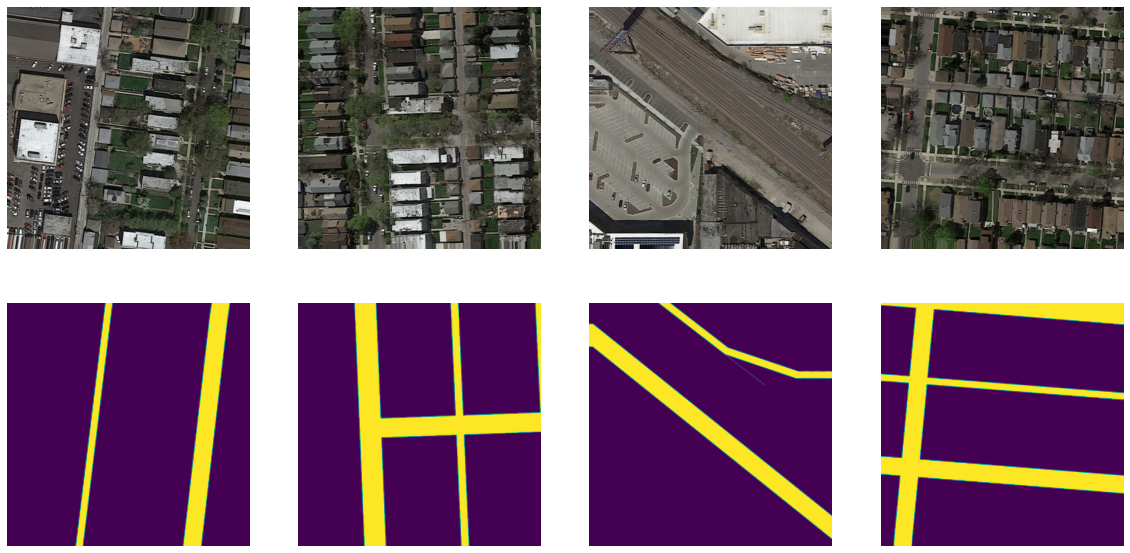

In [13]:
# generate samples and plot
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

# generate batch of images
for i in range(4):

    # convert to unsigned integers
    image_train = next(image_generator)[0]
    image_mask = np.squeeze(next(mask_generator)[0])
 
    # plot image
    ax[0,i].imshow(image_train)
    ax[0,i].axis('off')
    ax[1,i].imshow(image_mask)
    ax[1,i].axis('off')

# U-net for predictions

## Define the model

In [14]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#s = Lambda(lambda x: x / 255) (inputs)

#cropped = RandomCrop(256, 256) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 400, 400, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
EPOCHS = 20
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

In [16]:
opt = keras.optimizers.Adam(LEARNING_RATE)
bce = tf.keras.losses.BinaryCrossentropy()
model.compile(
      optimizer=opt,
      loss=bce,
      metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

## Train the model

In [17]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=100,
                    validation_data=(test_images, test_masks),
                    batch_size = BATCH_SIZE)

Epoch 1/20
100/100 [==============================] - 119s 1s/step - loss: 0.6481 - precision: 0.3994 - recall: 0.6977 - val_loss: 0.5536 - val_precision: 0.3484 - val_recall: 0.1038
Epoch 2/20
100/100 [==============================] - 116s 1s/step - loss: 0.4650 - precision: 0.7210 - recall: 0.7523 - val_loss: 0.4720 - val_precision: 0.7623 - val_recall: 0.1745
Epoch 3/20
100/100 [==============================] - 114s 1s/step - loss: 0.3926 - precision: 0.8512 - recall: 0.7498 - val_loss: 0.3950 - val_precision: 0.8770 - val_recall: 0.4578
Epoch 4/20
100/100 [==============================] - 113s 1s/step - loss: 0.3566 - precision: 0.8981 - recall: 0.7475 - val_loss: 0.3913 - val_precision: 0.8606 - val_recall: 0.7180
Epoch 5/20
100/100 [==============================] - 113s 1s/step - loss: 0.3320 - precision: 0.9239 - recall: 0.7464 - val_loss: 0.3789 - val_precision: 0.8678 - val_recall: 0.7373
Epoch 6/20
100/100 [==============================] - 113s 1s/step - loss: 0.3131 - p

## Save model and history

In [19]:
model.save(project_root_dir + "results/" + model_name + ".h5")

In [20]:
import pickle

pickle.dump(history.history, open(project_root_dir + "results/" + model_name + "_history.p", "wb"))

## Load model

In [21]:
model = load_model(project_root_dir + "results/" + model_name + ".h5")

## Evaluate model for test images

In [22]:
model.evaluate(test_images, test_masks)

1/1 [==============================] - 0s 2ms/step - loss: 0.2920 - precision: 0.8790 - recall: 0.7845


[0.29202061891555786, 0.8790228962898254, 0.784451425075531]

In [23]:
predictions = model.predict(test_images, verbose=1)
predictions_train = model.predict(train_images)

1/1 [==============================] - 0s 92ms/step


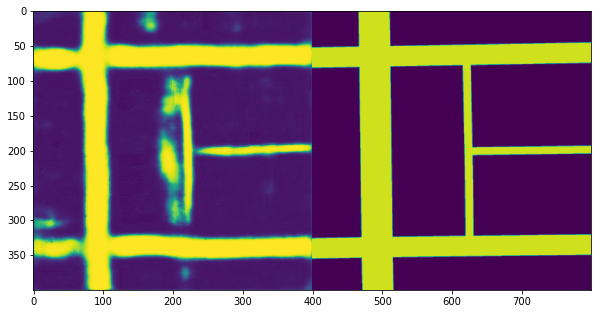

In [24]:
cimg = np.squeeze(concatenate_images(predictions[0], test_masks[0]))
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg)

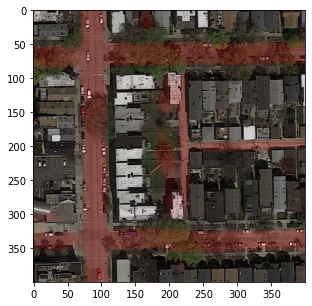

In [25]:
fig1 = plt.figure(figsize=(5, 5)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_images[0], np.squeeze(predictions[0]))

plt.imshow(new_img)

## Do predictions for the unlabeled data

In [26]:
predictions = []
for test_image in test_imgs:
    predictions.append(predict(test_image, model))
predictions = np.array(predictions)

1/1 [==============================] - 0s 21ms/step


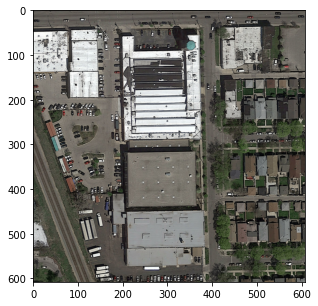

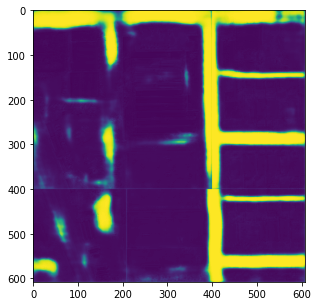

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(test_imgs[1])

plt.figure(figsize=(5,5))
plt.imshow(predictions[1])

In [29]:
submission_filename = project_root_dir + "results/" + model_name + '_submission.csv'
masks_to_submission(submission_filename, *predictions)